In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yaml
import os
import glob
import re
from matplotlib import pyplot as plt

import arviz as az

os.chdir('/home/jp4474/latent-abc-smc')

from models import TSMVAE
from lightning_module import PreTrainLightning
from systems import LotkaVolterra
from dataset import LotkaVolterraDataset
from scipy.integrate import solve_ivp

/home/jp4474/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jp4474/.local/lib/python3.10/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 7, in <module>
  File "/home/jp4474/.local/lib/python3.10/site-packages/numba_cuda/numba/cuda/cudadrv/runtime.py", line 111, in get_version
    self.cudaRuntimeGetVersion(ctypes.byref(rtver))
  File "/home/jp4474/.local/lib/python3.10/site-packages/numba_cuda/numba/cuda/cudadrv/runtime.py", line 65, in __getattr__
    self._initialize()
  File "/home/jp4474/.local/lib/python3.10/site-packages/numba_cuda/numba/cuda/cudadrv/runtime.py", line 51, in _initialize
    self.lib = open_cudalib('cudart')

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [6]:
folder_name = "/home/jp4474/latent-abc-smc/lotka_volterra_system/0.15/lotka_d64_ed32_6_8_4_8_ae_mask_0.15_noise_0.0"
config = yaml.safe_load(open(f"{folder_name}/config.yaml"))
model = TSMVAE(**config["model"]["params"], tokenize="linear")

pretrain_model_path = [f for f in os.listdir(folder_name) if f.endswith(".ckpt") and "TSMVAE" in f][0]
pl_model = PreTrainLightning.load_from_checkpoint(os.path.join(folder_name, pretrain_model_path), model = model)
pl_model.eval()
print("Successfully loaded model")

Successfully loaded model


In [7]:
train_ds = LotkaVolterraDataset(data_dir="data/Lotka")

In [8]:
lotka_abc = LotkaVolterra()
lotka_abc.update_model(pl_model)
lotka_abc.update_train_dataset(train_ds)

INFO:latent_abc_pmc:Initializing ViaABC class
INFO:latent_abc_pmc:Initialization complete
INFO:latent_abc_pmc:LatentABCSMC class initialized with the following parameters:
INFO:latent_abc_pmc:num_parameters: 2
INFO:latent_abc_pmc:Mu: [0 0]
INFO:latent_abc_pmc:Sigma: [10 10]
INFO:latent_abc_pmc:t0: 0
INFO:latent_abc_pmc:tmax: 15
INFO:latent_abc_pmc:time_space: [ 1.1  2.4  3.9  5.6  7.5  9.6 11.9 14.4]
INFO:latent_abc_pmc:pooling_method: no_cls
INFO:latent_abc_pmc:metric: pairwise_cosine
INFO:latent_abc_pmc:Model updated
INFO:latent_abc_pmc:Training dataset updated.


In [9]:
obs_data = np.load("data/Lotka/lotka_data.npz")
raw_np_scaled = lotka_abc.preprocess(obs_data["obs_data"])

In [10]:
with torch.no_grad():
    recon_loss, _, _, _, reconstruction = pl_model.forward(torch.tensor(raw_np_scaled).float().to(pl_model.device).unsqueeze(0))
    reconstruction = reconstruction.squeeze(0).cpu().numpy()

In [11]:
simulated_np, _ = lotka_abc.simulate([1,1])
simulated_np_scaled = lotka_abc.preprocess(simulated_np)

In [12]:
generations = np.load(f"{folder_name}/lotka_abc_cls_cosine_v2.npz", allow_pickle=True)['generations']

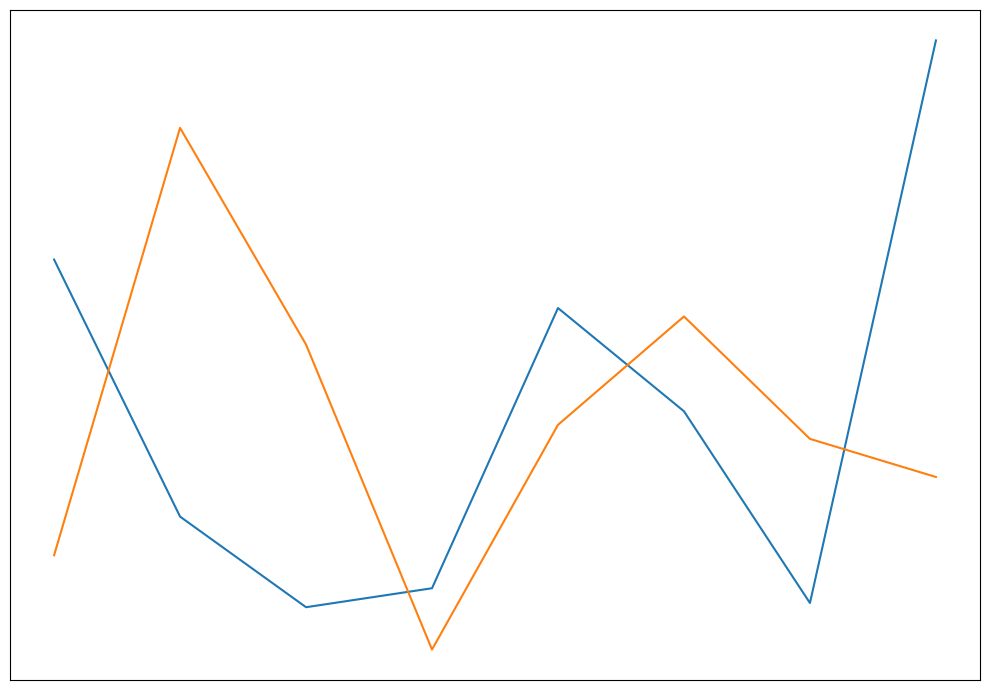

In [11]:
fig = plt.figure(figsize=(10, 7))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.plot(raw_np_scaled)
plt.savefig("sample_timeseries.png", dpi=300)

In [11]:
#np.random.seed(35)
#idx = np.random.randint(0, 50000, 5000)

In [12]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=False)
params = []
originals = []
reconstructions = []

with torch.no_grad():
    for x, y in train_dl:
        y = y.to(pl_model.device)
        _, _, _, _, reconstruction = pl_model.forward(y.float())
        reconstruction = reconstruction.squeeze(0).cpu().numpy()
        originals.append(y.cpu().numpy())
        params.append(x.cpu().numpy())
        reconstructions.append(reconstruction)

params = np.concatenate(params, axis=0)
originals = np.concatenate(originals, axis=0)
reconstructions = np.concatenate(reconstructions, axis=0)
scales = train_ds.s


In [13]:
# Step 1: Multiply and index
o = originals * scales
o_filtered = o #[idx]
#o = o[idx]

# Step 2: Filter where ALL values in 2nd and 3rd dims are <= 100
# mask1 = np.all(o >= 1000, axis=(1, 2))
# o_filtered = o[mask1]

# Step 3: Filter where ALL log-transformed values are >= 1e-10
# log_vals = np.log(o + 1e-4)
# mask2 = np.all(log_vals <= 1e-12, axis=(1, 2))
# o_filtered = o[mask2]


In [14]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# for i in range(o_filtered.shape[0]):
#     ax[0].semilogy(lotka_abc.time_space, o_filtered[i,:,0], color = "gray", alpha = 0.002)
#     ax[1].semilogy(lotka_abc.time_space, o_filtered[i,:,1], color = "gray", alpha = 0.002)

# ax[0].scatter(lotka_abc.time_space, lotka_abc.raw_observational_data[:,0], s=100, zorder=10)
# ax[1].scatter(lotka_abc.time_space, lotka_abc.raw_observational_data[:,1], s=100, color = "orange", zorder=10)
# ax[0].set_ylim(1e-6, 1e2)
# ax[1].set_ylim(1e-6, 1e2)

# #plt.show()
# plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1_traj.png", dpi=300, bbox_inches='tight')

In [15]:
np.random.seed(35)
idx = np.random.randint(0, 50000, 5000)

In [16]:
parameters = params[idx,:]
original_samples_to_plot = originals[idx,:]
reconstructed_samples_to_plot = reconstructions[idx,:]
scales = train_ds.s[idx].squeeze(1)

In [17]:
scales.shape

(5000, 2)

# Masking

In [18]:
# Randomly choose 15% of index from 0 to 7, repeat 9 times
idx = np.random.choice(np.arange(8), size=9, replace=True)
idx = idx.reshape(9, 1)

In [19]:
recons = []
x_plot = []
with torch.no_grad():
    for data in original_samples_to_plot:
        data_preprocessd = lotka_abc.preprocess(data)
        input = torch.tensor(data_preprocessd).to(pl_model.device).float()
        recon, mask, ids_restore = pl_model.model.impute(input)
        ids_restore = ids_restore.cpu()
        mask = mask.cpu()

        #print(mask)
        # print(ids_restore)
        # print(ids_restore[mask.bool()])

        recon = recon.cpu().squeeze(0).numpy()
        recons.append(recon)
        temp = data.copy()
        temp[mask.bool()[0],:] = None
        #print(ids_restore[mask.bool()])
        x_plot.append(temp)

recons = np.array(recons)
x_plot = np.array(x_plot)

KeyboardInterrupt: 

In [20]:
scales.shape

(5000, 2)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'P', 'T', 'a', 'd', 'e', 'five', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 'six', 'space', 't', 'three', 'two', 'u', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 51, 55, 68, 71, 72, 76, 79, 80, 81, 82, 83, 85, 87, 88, 92]
INFO:fontTools.subset:Closed glyph list over 'MATH': 26 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'P', 'T', 'a', 'd', 'e', 'five', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 

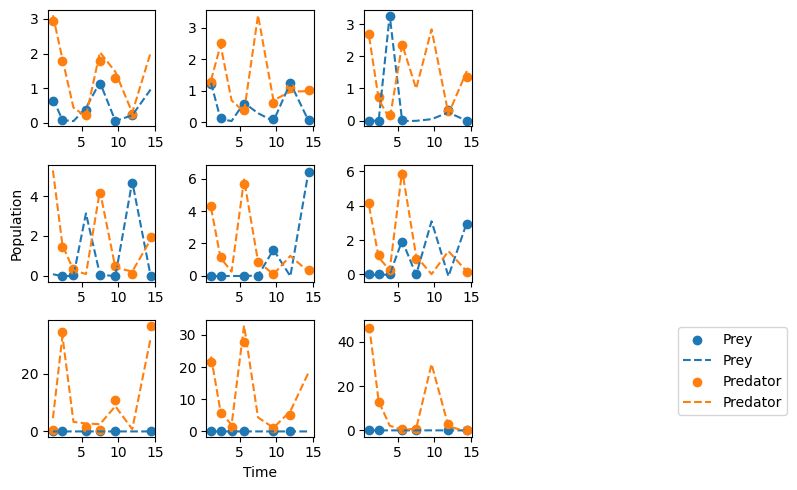

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(5, 5))
# font size
#plt.rcParams.update({'font.size': 12})
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(lotka_abc.time_space, x_plot[i*3+j, :, 0] * scales[i][0], label="Prey")
        ax[i,j].plot(lotka_abc.time_space, recons[i*3+j, :, 0] * scales[i][0], label="Prey", linestyle='dashed')
        ax[i,j].scatter(lotka_abc.time_space, x_plot[i*3+j, :, 1] * scales[i][1], label="Predator")
        ax[i,j].plot(lotka_abc.time_space, recons[i*3+j, :, 1] * scales[i][1], label="Predator", linestyle='dashed')
        #ax[i,j].set_title(f"Sample {idx[i*3+j]}")
        #ax[i,j].legend()

        if i*3+j == 7:
            ax[i,j].set_xlabel("Time")
        if i*3+j == 3:
            ax[i,j].set_ylabel("Population")
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(4, 1))
plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1a.pdf", dpi=300, bbox_inches='tight')
#plt.show()

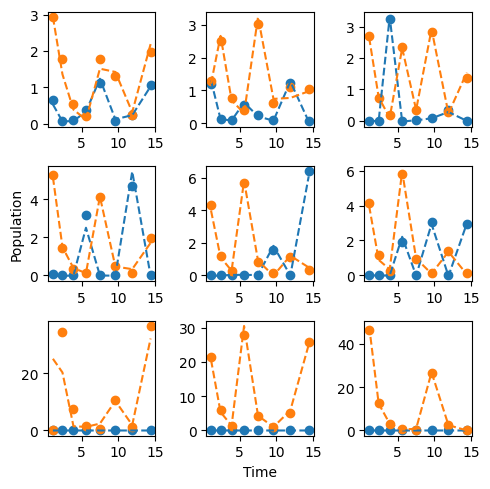

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(5, 5))
# font size
#plt.rcParams.update({'font.size': 14})
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(lotka_abc.time_space, original_samples_to_plot[i*3+j, :, 0] * scales[i][0], label="Prey")
        ax[i,j].plot(lotka_abc.time_space, reconstructed_samples_to_plot[i*3+j, :, 0] * scales[i][0], label="Prey", linestyle='dashed')
        ax[i,j].scatter(lotka_abc.time_space, original_samples_to_plot[i*3+j, :, 1] * scales[i][1], label="Predator")
        ax[i,j].plot(lotka_abc.time_space, reconstructed_samples_to_plot[i*3+j, :, 1] * scales[i][1], label="Predator", linestyle='dashed')
        #ax[i,j].set_title(f"Sample {idx[i*3+j]}")
        #ax[i,j].legend()

        if i*3+j == 7:
            ax[i,j].set_xlabel("Time")
        if i*3+j == 3:
            ax[i,j].set_ylabel("Population")
plt.tight_layout()
#plt.legend(loc='upper right', bbox_to_anchor=(4, 1))
#plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1b.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Observational Data

In [14]:
scales = lotka_abc.raw_observational_data.mean(axis=0)

In [15]:
solution = solve_ivp(lotka_abc.ode_system, [lotka_abc.t0, lotka_abc.tmax], y0=lotka_abc.state0, t_eval=np.arange(0, 15, 0.01), args=([1, 1],))

In [16]:
solution.y.shape

(2, 1500)

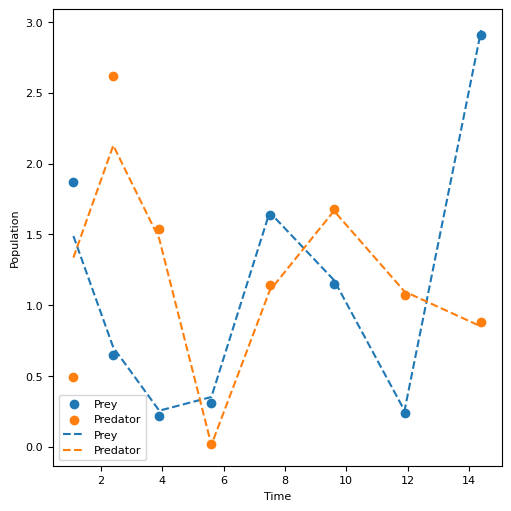

In [17]:
with torch.no_grad():
    recon_loss, _, _, _, reconstruction = pl_model.forward(torch.tensor(raw_np_scaled).float().to(pl_model.device).unsqueeze(0))
    reconstruction = reconstruction.squeeze(0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# font size
plt.rcParams.update({'font.size': 8})

ax.scatter(lotka_abc.time_space, lotka_abc.raw_observational_data[:,0], label="Prey")
ax.scatter(lotka_abc.time_space, lotka_abc.raw_observational_data[:,1], label="Predator")
ax.plot(lotka_abc.time_space, reconstruction[:,0] * scales[0], label="Prey", linestyle='dashed')
ax.plot(lotka_abc.time_space, reconstruction[:,1] * scales[1], label="Predator", linestyle='dashed')
#ax.plot(lotka_abc.time_space, obs_data['ground_truth'])
#ax.plot(np.arange(0, 15, 0.01), solution.y[0], alpha=0.5)
#ax.plot(np.arange(0, 15, 0.01), solution.y[1], alpha=0.5)
plt.tight_layout()
ax.set_xlabel("Time")
ax.set_ylabel("Population")
plt.legend()
plt.show()
#plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1c_1.pdf", dpi=1000)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# font size
plt.rcParams.update({'font.size': 8})

#ax.scatter(lotka_abc.time_space, lotka_abc.raw_observational_data[:,0], label="Prey")
#ax.scatter(lotka_abc.time_space, lotka_abc.raw_observational_data[:,1], label="Predator")
ax.plot(lotka_abc.time_space, reconstruction[:,0] * scales[0], label="Prey", linestyle='dashed')
ax.plot(lotka_abc.time_space, reconstruction[:,1] * scales[1], label="Predator", linestyle='dashed')
ax.scatter(lotka_abc.time_space, obs_data['ground_truth'][:,0])
ax.scatter(lotka_abc.time_space, obs_data['ground_truth'][:,1])

#ax.plot(np.arange(0, 15, 0.01), solution.y[0], alpha=0.5)
#ax.plot(np.arange(0, 15, 0.01), solution.y[1], alpha=0.5)
plt.tight_layout()
ax.set_xlabel("Time")
ax.set_ylabel("Population")
plt.legend()
plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1c_1.pdf", dpi=1000)


In [18]:
generations = np.load(f"{folder_name}/lotka_abc_cls_cosine_v2.npz", allow_pickle=True)['generations']

In [19]:
final_posterior = generations[-1]
final_particles = final_posterior['particles']
final_weights = final_posterior['weights']
epsilon = np.array([gen['epsilon'] for gen in generations])
simulations = np.array([gen['simulations'] for gen in generations])
acceptance_rates = 1000/simulations
t = np.arange(1, len(generations)+1)

In [22]:
trajectories = np.zeros((len(final_particles), 2, 1500))
for i, param_set in enumerate(final_particles):
    param_set = np.array(param_set)
    solution = solve_ivp(lotka_abc.ode_system, [lotka_abc.t0, lotka_abc.tmax], y0=lotka_abc.state0, t_eval=np.arange(0, 15, 0.01), args=(param_set,))
    trajectories[i] = solution.y

trajectories.shape

(1000, 2, 1500)

In [23]:
final_particles.shape

(1000, 2)

In [24]:
final_particles[10]

array([1.21758296, 0.78164213])

In [25]:
trajectories = np.zeros((len(final_particles), 2, 1500))
for i in range(1000):
    # choose final particles
    idx = np.random.choice(np.arange(0, 1000, 1), size=1, p=final_weights)
    param_set = np.array(final_particles[idx])[0]
    solution = solve_ivp(lotka_abc.ode_system, [lotka_abc.t0, lotka_abc.tmax], y0=lotka_abc.state0, t_eval=np.arange(0, 15, 0.01), args=(param_set,))
    trajectories[i] = solution.y
trajectories.shape

(1000, 2, 1500)

In [26]:
trajectories.mean(axis=0)[0].shape

(1500,)

In [27]:
x = np.arange(0, 15, 0.01)
mean_trajectories = trajectories.mean(axis=0)
mean_trajectories = np.percentile(trajectories, 50, axis = 0)

In [28]:
confidence_interval = 0.95
lower_bound = np.percentile(trajectories, (1-confidence_interval)/2*100, axis=0)
upper_bound = np.percentile(trajectories, (1+confidence_interval)/2*100, axis=0)

In [29]:
lower_bound.shape

(2, 1500)

In [32]:
observational_data_trajectory = np.load("data/Lotka/lotka_data.npz")["obs_data"]
ground_truth_trajectory = solve_ivp(lotka_abc.ode_system, [lotka_abc.t0, lotka_abc.tmax], y0=lotka_abc.state0, t_eval=np.arange(0, 15, 0.01), args=([1.,1.],)).y

In [33]:
ground_truth_trajectory

array([[1.        , 1.00501248, 1.01004983, ..., 1.64301011, 1.6375469 ,
        1.63196271],
       [0.5       , 0.50001252, 0.50005017, ..., 1.32879348, 1.33732911,
        1.34584519]])

Text(0.5, 1.0, 'Predator')

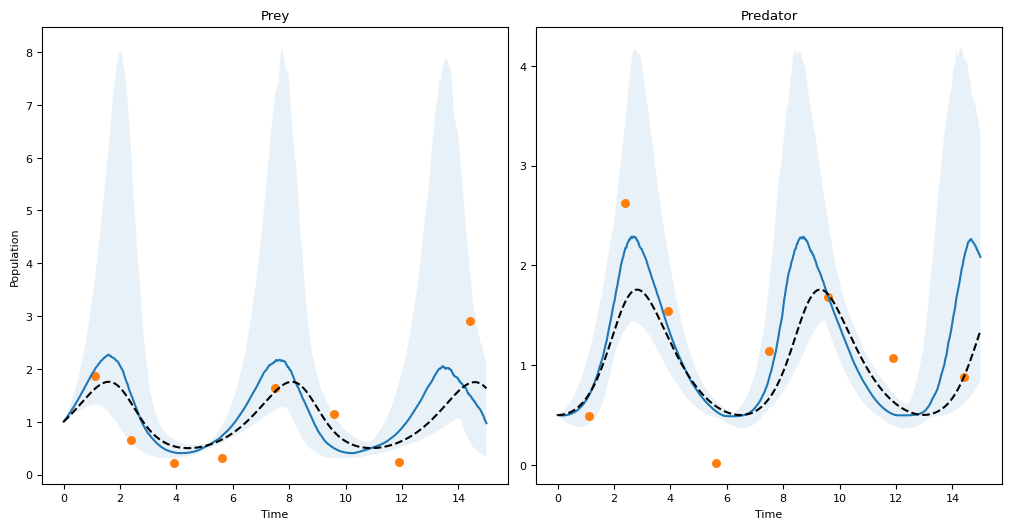

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(x, mean_trajectories[0], label="Prey")
ax[0].fill_between(x, lower_bound[0], upper_bound[0], alpha=0.1)
ax[0].scatter(lotka_abc.time_space, observational_data_trajectory[:,0], label="Prey", s=30)
ax[0].plot(x, ground_truth_trajectory[0], label="Ground Truth", color='black', linestyle='--')

ax[1].plot(x, mean_trajectories[1], label="Predator")
ax[1].fill_between(x, lower_bound[1], upper_bound[1], alpha=0.1)
ax[1].scatter(lotka_abc.time_space, observational_data_trajectory[:,1], label="Predator", s=30)
ax[1].plot(x, ground_truth_trajectory[1], label="Ground Truth", color='black', linestyle='--')

plt.tight_layout()
ax[0].set_ylabel("Population")
ax[0].set_xlabel("Time")
ax[1].set_xlabel("Time")
ax[0].set_title("Prey")
ax[1].set_title("Predator")

#plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1f_1.pdf", dpi=300)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
import numpy as np

x = final_particles[:, 0]
y = final_particles[:, 1]

# Estimate 2D density
xy = np.vstack([x, y])
kde = gaussian_kde(xy, weights=final_weights)
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = kde(np.vstack([xi.ravel(), yi.ravel()]))

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
    
#ax_main.scatter(x, y, c=final_weights, cmap="viridis", marker='.')
# Filled contour plot
cf = ax_main.contourf(xi, yi, zi.reshape(xi.shape))
#fig.colorbar(cf, ax=ax_main)
ax_main.set(xlabel="a", ylabel="b")

#plt.colorbar(ax_main.collections[0], ax=ax_main)

ax_main.set(xlabel="a", ylabel="b")

ax_xDist.hist(x,bins=30,align='mid', color="gray")
ax_xDist.set(ylabel='count')

ax_yDist.hist(y,bins=30,orientation='horizontal',align='mid', color="gray")
ax_yDist.set(xlabel='count')

plt.savefig(f"/home/jp4474/latent-abc-smc/notebooks_lotka/figures/figure_1f_2.pdf", dpi=300)
plt.show()